# IMPORTS

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from tqdm.auto import tqdm

# Preparing Dataset

In [6]:
data='/kaggle/input/shoe-dataset/shoeTypeClassifierDataset'

In [7]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        if len(image.shape) == 3 and image.shape[2] == 3:  
            image = image.mean(axis=2) 
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(image_filename, fontsize=8)

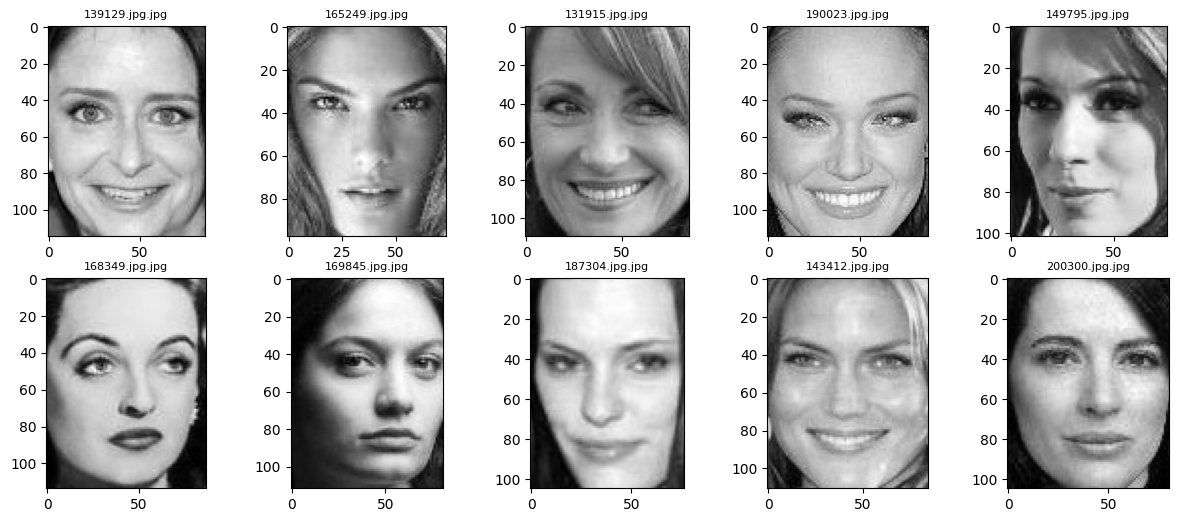

In [8]:
female_dir='/kaggle/input/gender-classification-dataset/Training/female'
visualize_images(female_dir)

In [278]:
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [280]:
train_data='/kaggle/input/gender-classification-dataset/Training'
valid_data='/kaggle/input/gender-classification-dataset/Validation'

In [281]:
train_data=datasets.ImageFolder(train_data,transform=transform)

In [282]:
classes=train_data.classes
classes

['female', 'male']

In [283]:
train_data.__len__()

47009

In [284]:
valid_data=datasets.ImageFolder(valid_data,transform=transform)
valid_data.__len__()

11649

In [ ]:
# train_size=int(0.8*len(train_data))
# valid_size=len(train_data)-train_size

In [ ]:
# train_data,valid_data=random_split(train_data,[train_size,valid_size])

In [285]:
print("length of train dataset: ",len(train_data))
print("length of val dataset: ",len(valid_data))
# print("length of test dataset: ",len(test_data))

length of train dataset:  47009
length of val dataset:  11649


In [286]:
train_data[0][0].shape

torch.Size([3, 64, 64])

In [287]:
BATCH_SIZE=128
LR=1e-4
BETAS=(0.5,0.999)
NUM_EPOCHS=50
z_dim=100

In [288]:
train_loader=DataLoader(train_data,BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(valid_data,BATCH_SIZE,shuffle=True)

In [289]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [290]:
mappings=valid_data.class_to_idx
mappings

{'female': 0, 'male': 1}

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim,1,1).to(device) 

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator

In [291]:
class Generator(nn.Module):
    def __init__(self,embed_size=100,z_dim=100,im_chan=3,hidden_dim=64,num_classes=2):
        super(Generator,self).__init__()
        self.z_dim=z_dim
        self.initial_layer = nn.Linear(z_dim + embed_size, hidden_dim * 16 * 4 * 4)
        self.gen=nn.Sequential(
            nn.ConvTranspose2d(z_dim+100,hidden_dim*16,4,1,0),
            nn.BatchNorm2d(hidden_dim*16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*16,hidden_dim*8,4,2,1),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*8,hidden_dim*4,4,2,1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*4,hidden_dim*2,4,2,1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            
#             nn.ConvTranspose2d(hidden_dim*2,hidden_dim,4,2,1),
#             nn.BatchNorm2d(hidden_dim),
#             nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*2,3,4,2,1),
#             nn.BatchNorm2d(hidden_dim*2),
#             nn.ReLU(inplace=True),
            nn.Tanh()
        )
        self.embedding = nn.Embedding(num_classes, embed_size)
        
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    
    def forward(self,x,labels):
        embeddings=self.embedding(labels).unsqueeze(2).unsqueeze(3)
        x=torch.cat([x,embeddings],dim=1)
#         x = self.initial_layer(x)
#         x = x.view(x.size(0), -1, 4, 4)
        return self.gen(x)

## Testing Generator

In [ ]:
gen=Generator(100).to(device)

In [ ]:
fake_noise=get_noise(128,100).to(device)

In [ ]:
label=torch.tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])

In [314]:
fake=gen(fake_noise,label.to(device))
fake.shape

torch.Size([128, 3, 64, 64])

# Discriminator

In [312]:
class Discriminator(nn.Module):
    def __init__(self,img_chan=3,hidden_dim=64,num_classes=2,img_size=64):
        super(Discriminator,self).__init__()
        self.num_classes=num_classes
        self.img_size=img_size
        self.disc=nn.Sequential(
            nn.Conv2d(img_chan+1,hidden_dim,4,2,1),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(hidden_dim,hidden_dim*2,4,2,1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(hidden_dim*2,hidden_dim*4,4,2,1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(hidden_dim*4,hidden_dim*8,4,2,1),
            nn.BatchNorm2d(hidden_dim*8),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(hidden_dim*8,1,4,2,1),
#             nn.BatchNorm2d(hidden_dim*2),
#             nn.LeakyReLU(0.2,inplace=True),
            nn.Sigmoid()
            
        )
        self.embedding=nn.Embedding(num_classes,img_size*img_size)
        
    def forward(self,x,labels):
        embedding=self.embedding(labels).view(labels.shape[0],1,self.img_size,self.img_size)
#         print(embedding.shape)
#         print(x.shape)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

## Testing Discriminator

In [ ]:
disc=Discriminator().to(device)

In [ ]:
disc.train()

In [ ]:
prob=disc(fake,label.to(device))

# Initialization

In [313]:
gen=Generator(100).to(device)
disc=Discriminator().to(device)

In [315]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)

In [316]:
criterion=nn.BCELoss()

In [318]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [319]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Sigmoid()
  )
  (embedding): Embedding(2, 4096)
)

In [300]:
fixed_noise=torch.rand(32,100,1,1)
step=0

In [303]:
fake_noise=get_noise(128,100).to(device)

In [304]:
label.shape

torch.Size([128])

In [305]:
fake_noise.shape

torch.Size([128, 100, 1, 1])

In [306]:
fake=gen(fake_noise,label.to(device))

In [307]:
fake.shape

torch.Size([128, 3, 64, 64])

In [308]:
label

tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')

# Training Loop

In [309]:
from tqdm.auto import tqdm

In [320]:
mean_discriminator_loss=0
mean_generator_loss = 0
cur_step = 0
display_step = 350

In [ ]:
for epoch in range(NUM_EPOCHS):
    for real,labels in tqdm(train_loader):
        cur_batch_size=len(real)
        labels=labels.to(device)
        real=real.to(device)
        label=labels
        disc_opt.zero_grad()
        fake_noise=get_noise(cur_batch_size,z_dim,device=device)
        fake=gen(fake_noise,labels)
        disc_fake_pred=disc(fake.detach(),labels)
        
        disc_fake_loss=criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_pred=disc(real,labels)
        disc_real_loss=criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss=(disc_fake_loss+disc_real_loss)/2
        mean_discriminator_loss+=disc_loss.item()/display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2,labels)
        disc_fake_pred = disc(fake_2,labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

## Saving Trained Model after 20 epochs

In [403]:
torch.save(gen.state_dict(), '/kaggle/working/gen.pth')
torch.save(disc.state_dict(), '/kaggle/working/disc.pth')

In [322]:
import cv2 as cv

In [323]:
train_data_dir='/kaggle/input/gender-classification-dataset/Training'

In [324]:
train_data_dir=datasets.ImageFolder(train_data_dir,transform=transform)

In [329]:
img=train_data_dir[0][0].numpy()

In [ ]:
os.makedirs("Training")
os.makedirs("Validation")
os.makedirs("Training/female")
os.makedirs("Training/male")
os.makedirs("Validation/male")
os.makedirs("Validation/female")

# Apllying Canny to use in Pix2Pix

In [386]:
img = cv.imread("/kaggle/input/gender-classification-dataset/Training/female/131422.jpg.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [374]:
edges=cv.Canny(img,100,200)

In [381]:
imgconc = cv.hconcat([img, edges])

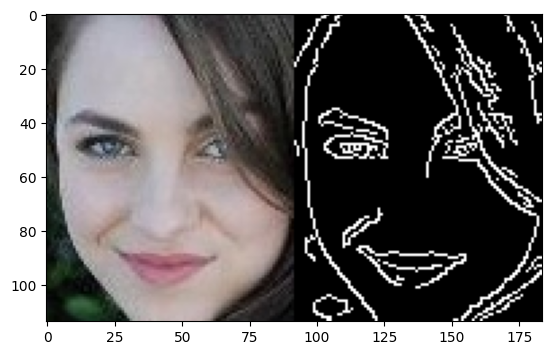

In [382]:
plt.imshow(imgconc)

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        img = cv.imread(os.path.join(dirname, filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        edges=cv.Canny(img,100,200)
        edges = cv.cvtColor(edges, cv.COLOR_BGR2RGB)
        img = cv.hconcat([img, edges])
#         img=torch.from_numpy(img)
#         save_image(img, os.path.join(dirname,'img',str(filename)))
        cv.imwrite(os.path.join(dirname,'img',str(filename)),img)
        